In [1]:
library(dlnm)
library(mgcv)
library(data.table)
library(plotly)
library(ggplot2)
library(splines)
library(parallel)
library(doParallel)
library(foreach)
library(coda)
library(lubridate)
library(xts)
library(timetk)
library(forecast)
library(gridExtra)
library(tidyr)
library(dplyr)
library(Hmisc)
library(xtable)
library(MuMIn)
library(dlnm) ; library(splines) ; library(MASS) ; library(tsModel)

This is dlnm 2.4.7. For details: help(dlnm) and vignette('dlnmOverview').

Loading required package: nlme

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: ggplot2


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout


Loading required package: foreach

Loading required package: iterators


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked fro

# MODEL SELECTION
## AT01 and AT03 (only change AT03 to AT01 or viceversa)

In [8]:
################################################################################
# READ DATA
################################################################################
data <- read.csv("modelling_data/weekly_data.csv")
dlnm_selection <- head(read.csv("dlnm_tuning/AT03_dlnm_model_selection.csv"),24)

################################################################################
# DATA VARIABLES SPLIT
# ################################################################################
data <- data %>% dplyr:::select(
                                at_code,
                                events,
                                asir,
                                temp = max_temp,
                                hum = min_hum,
                                is_holiday,
                                month,
                                year,
                                pm10 = mean_PM10,
                                o3 = mean_O3,
                                no2 = mean_NO2,
                                so2 = mean_SO2,
                                co = mean_CO
                                )

#January, February, November, and December <– Paper 2019

# Function to categorize each month into a season
categorize_season <- function(month) {
  if (month %in% c(1, 2, 11, 12)) {
    return("Winter")
  } else {
    return("Summer")
  }
}

# Add a new column "season" to the environmeAMIet based on the month
data$season <- sapply(data$month, categorize_season)
data$asir <- round(data$asir * 100, digits = 0)
# ################################################################################
# AT CODE
# ################################################################################
data = data[(data$at_code=="AT03"),]
#data$date <- as.Date(data$date)
#Simulate a date column based on month and year
#data$date <- as.Date(paste(data$year, data$month, "01", sep="-"))
library(dlnm)
library(splines)
library(progress) 

# Possible degrees of freedom for argvar and arglag
df_options <- c(2, 3)

# Dataframe to store results
results <- data.frame(model = character(), variables = character(), df_pm10 = character(), df_hum = character(), 
                      df_no2 = character(), df_temp = character(), df_so2 = character(), df_co = character(), 
                      is_holiday = logical(), residual_dispersion = numeric(), AIC = numeric(), stringsAsFactors = FALSE)

# Define variable combinations for modeling
variable_sets <- list(
  c("hum"),
  c("temp"),
  #c("pm10"),
  #c("so2"),
  c("hum", "temp"),
  c("hum", "o3"),
  c("hum", "temp", "pm10"),
  c("hum", "temp", "no2"),
  c("hum", "temp", "so2"),
  #c("hum", "temp", "co"),
  #c("hum", "temp", "pm10", "o3"),
  #c("hum", "temp", "pm10", "no2"),
  #c("hum", "temp", "so2", "no2"),
  #c("hum", "temp", "pm10", "o3", "no2"),
  #c("hum", "temp", "pm10", "so2", "no2"),
  #c("hum", "temp", "pm10", "o3", "no2", "so2"),
   c("hum", "temp", "pm10", "o3", "no2", "so2", "co")
)

# Generate all combinations of df settings
df_combinations <- expand.grid(df_pm10_var=df_options, df_pm10_lag=df_options, 
                               df_hum_var=df_options, df_hum_lag=df_options, 
                               df_no2_var=df_options, df_no2_lag=df_options, 
                               df_temp_var=df_options, df_temp_lag=df_options, 
                               df_so2_var=df_options, df_so2_lag=df_options, 
                               df_co_var=df_options, df_co_lag=df_options)


# Initialize tqdm progress bar
pb <- txtProgressBar(min = 0,      # Minimum value of the progress bar
                     max = nrow(df_combinations), # Maximum value of the progress bar
                     style = 3,    # Progress bar style (also available style = 1 and style = 2)
                     width = 50,   # Progress bar width. Defaults to getOption("width")
                     char = "=")   # Character used to create the bar


# Loop over each combination of df settings, variable sets, and holiday inclusion
for (i in 1:nrow(df_combinations)) {
  df_comb <- df_combinations[i,]
  
  # Create crossbasis functions with current df settings
  cb_pm10 <- crossbasis(data$pm10, lag=12, 
                        argvar=list(fun="ns", df=df_comb$df_pm10_var), 
                        arglag=list(fun="ns", df=df_comb$df_pm10_lag))
  
  cb_hum <- crossbasis(data$hum, lag=12, 
                       argvar=list(fun="ns", df=df_comb$df_hum_var), 
                       arglag=list(fun="ns", df=df_comb$df_hum_lag))
  
  cb_no2 <- crossbasis(data$no2, lag=12, 
                       argvar=list(fun="ns", df=df_comb$df_no2_var), 
                       arglag=list(fun="ns", df=df_comb$df_no2_lag))
  
  cb_temp <- crossbasis(data$temp, lag=12, 
                        argvar=list(fun="ns", df=df_comb$df_temp_var), 
                        arglag=list(fun="ns", df=df_comb$df_temp_lag))
  
  cb_so2 <- crossbasis(data$so2, lag=12, 
                       argvar=list(fun="ns", df=df_comb$df_so2_var), 
                       arglag=list(fun="ns", df=df_comb$df_so2_lag))
  
  cb_co <- crossbasis(data$co, lag=12, 
                      argvar=list(fun="ns", df=df_comb$df_co_var), 
                      arglag=list(fun="ns", df=df_comb$df_co_lag))
  
  for (vars in variable_sets) {
    for (holiday in c(TRUE, FALSE)) {
      # Build the formula dynamically
      formula_vars <- paste(vars, collapse = " + ")
      if (holiday) {
        formula_vars <- paste(formula_vars, "+ is_holiday")
      }
      #formula <- as.formula(paste("events ~", formula_vars, "+ ns(year, df=3) + factor(season)"))
      formula <- as.formula(paste("asir ~", formula_vars, "+ ns(year, df=3) + factor(season)"))
      
      # Fit the model
      model <- glm(formula, data = data, family = poisson)
      
      # Calculate residual dispersion
      residual_deviance <- model$deviance
      
      # Calculate AIC
      aic <- AIC(model)
      
      # Store the results
      results <- rbind(results, data.frame(model = paste("Model", i), 
                                           variables = formula_vars, 
                                           df_pm10 = paste(df_comb$df_pm10_var, df_comb$df_pm10_lag, sep = ","), 
                                           df_hum = paste(df_comb$df_hum_var, df_comb$df_hum_lag, sep = ","), 
                                           df_no2 = paste(df_comb$df_no2_var, df_comb$df_no2_lag, sep = ","), 
                                           df_temp = paste(df_comb$df_temp_var, df_comb$df_temp_lag, sep = ","), 
                                           df_so2 = paste(df_comb$df_so2_var, df_comb$df_so2_lag, sep = ","), 
                                           df_co = paste(df_comb$df_co_var, df_comb$df_co_lag, sep = ","), 
                                           is_holiday = holiday, 
                                           residual_deviance = residual_deviance, 
                                           AIC = aic))
    }
  }
  # Update progress bar - sets the progress bar to the current state
  setTxtProgressBar(pb, i)  # Update the progress bar
}
# Just append the previously found results
results['data_split'] <- 'max'
results['year_df'] <- 3
results <- results %>% arrange(AIC, residual_deviance)

# SAVE
write.csv(results, "dlnm_tuning/AT03_best_model_weekly_asir.csv", row.names = FALSE)

  |==================================================| 100%

# BEST MODEL AT03 - events

In [30]:
dlnm_selection03 <- read.csv("dlnm_tuning/AT03_best_model_weekly.csv")

# Select distinct rows based on the 'variables' column
dlnm_selection03_unique <- dlnm_selection03 %>%
  distinct(variables, .keep_all = TRUE)

# Display the resulting dataframe
dlnm_selection03_unique

model,variables,df_pm10,df_hum,df_no2,df_temp,df_so2,df_co,is_holiday,residual_deviance,AIC,data_split,year_df
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<chr>,<int>
Model 1,temp + is_holiday,"2,2","2,2","2,2","2,2","2,2","2,2",TRUE,542.9816,1846.134,max,3
Model 1,temp,"2,2","2,2","2,2","2,2","2,2","2,2",FALSE,545.4288,1846.581,max,3
Model 1,hum + temp + is_holiday,"2,2","2,2","2,2","2,2","2,2","2,2",TRUE,542.4187,1847.571,max,3
Model 1,hum + is_holiday,"2,2","2,2","2,2","2,2","2,2","2,2",TRUE,544.7480,1847.900,max,3
Model 1,hum + temp,"2,2","2,2","2,2","2,2","2,2","2,2",FALSE,544.7889,1847.941,max,3
Model 1,hum,"2,2","2,2","2,2","2,2","2,2","2,2",FALSE,547.1240,1848.276,max,3
Model 1,hum + temp + so2 + is_holiday,"2,2","2,2","2,2","2,2","2,2","2,2",TRUE,541.2900,1848.442,max,3
Model 1,hum + temp + so2,"2,2","2,2","2,2","2,2","2,2","2,2",FALSE,543.5413,1848.694,max,3
Model 1,hum + o3 + is_holiday,"2,2","2,2","2,2","2,2","2,2","2,2",TRUE,543.7536,1848.906,max,3



Call:
glm(formula = events ~ cb_pm10 + cb_hum + cb_temp + ns(year, 
    df = 3) + is_holiday, family = quasipoisson, data = data)

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.182441   0.492858   0.370 0.711434    
cb_pm10v1.l1       0.102252   0.102363   0.999 0.318383    
cb_pm10v1.l2      -0.013997   0.152497  -0.092 0.926913    
cb_pm10v2.l1       0.149188   0.162069   0.921 0.357804    
cb_pm10v2.l2      -0.070427   0.200292  -0.352 0.725289    
cb_humv1.l1        0.070658   0.120094   0.588 0.556591    
cb_humv1.l2       -0.297831   0.163954  -1.817 0.069966 .  
cb_humv2.l1       -0.164295   0.097709  -1.681 0.093378 .  
cb_humv2.l2        0.143368   0.119012   1.205 0.228986    
cb_tempv1.l1       0.009508   0.092433   0.103 0.918114    
cb_tempv1.l2       0.140031   0.143086   0.979 0.328290    
cb_tempv2.l1      -0.091895   0.044998  -2.042 0.041723 *  
cb_tempv2.l2       0.047541   0.081539   0.583 0.560162    
ns(year, df = 

centering value unspecified. Automatically set to 22.5

centering value unspecified. Automatically set to 40

centering value unspecified. Automatically set to 35



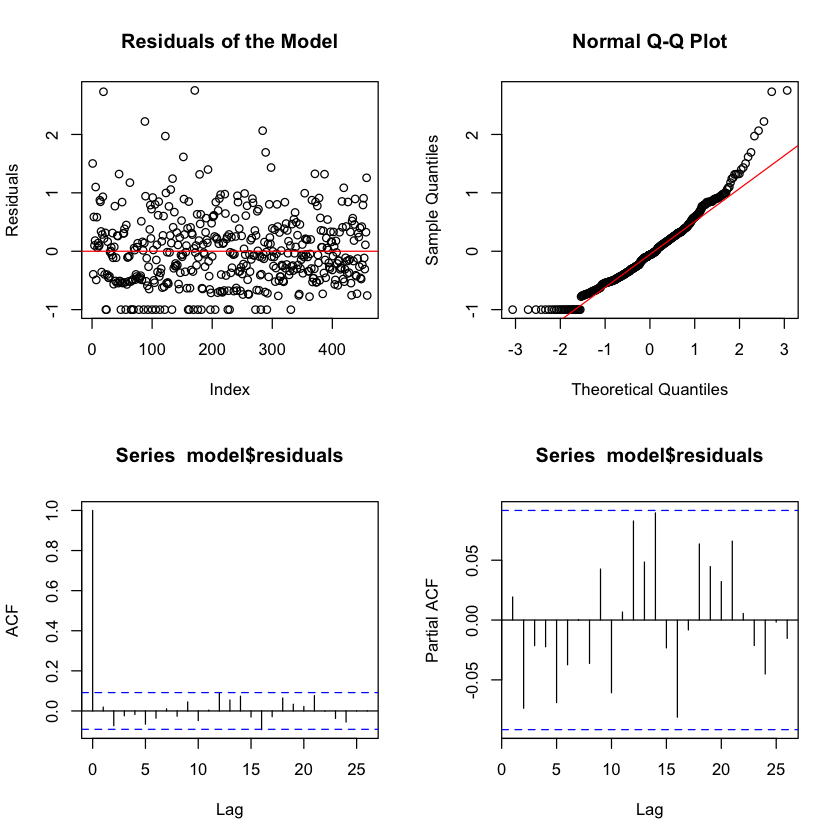

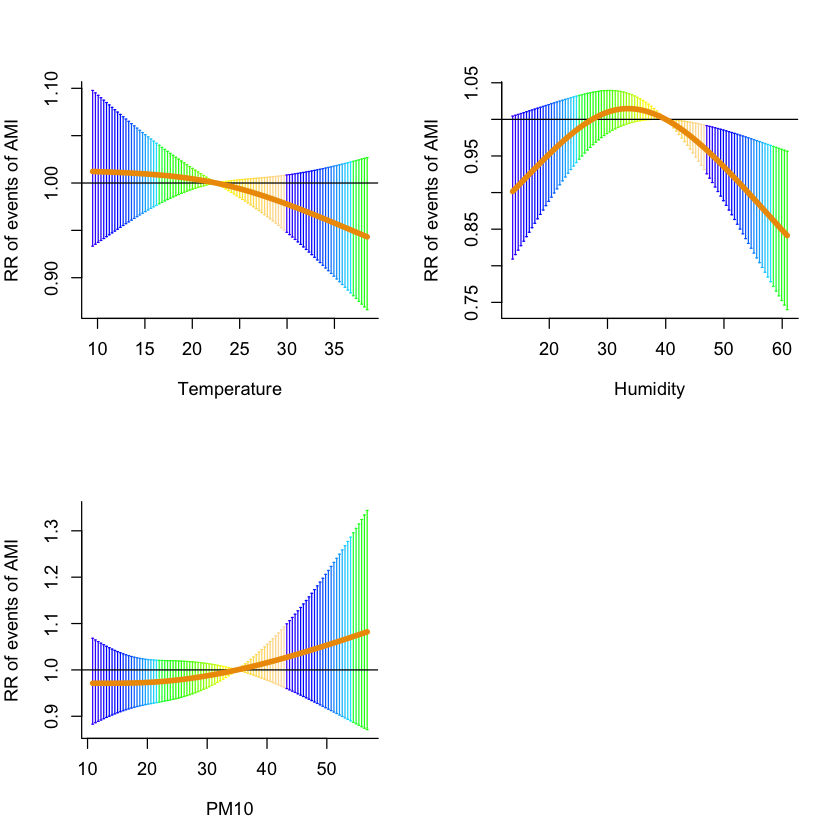

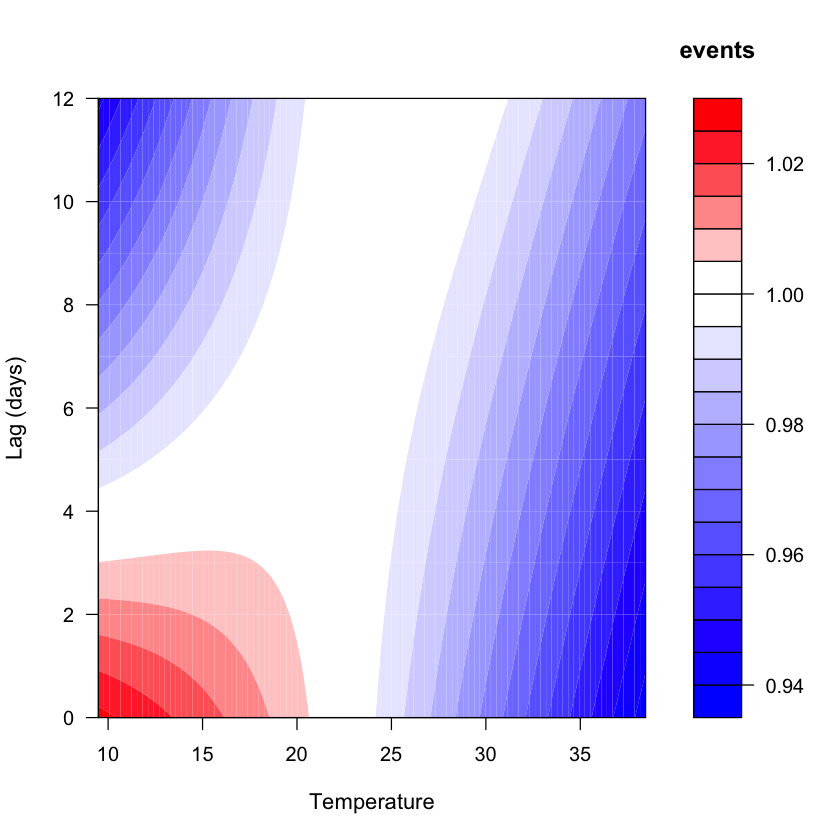

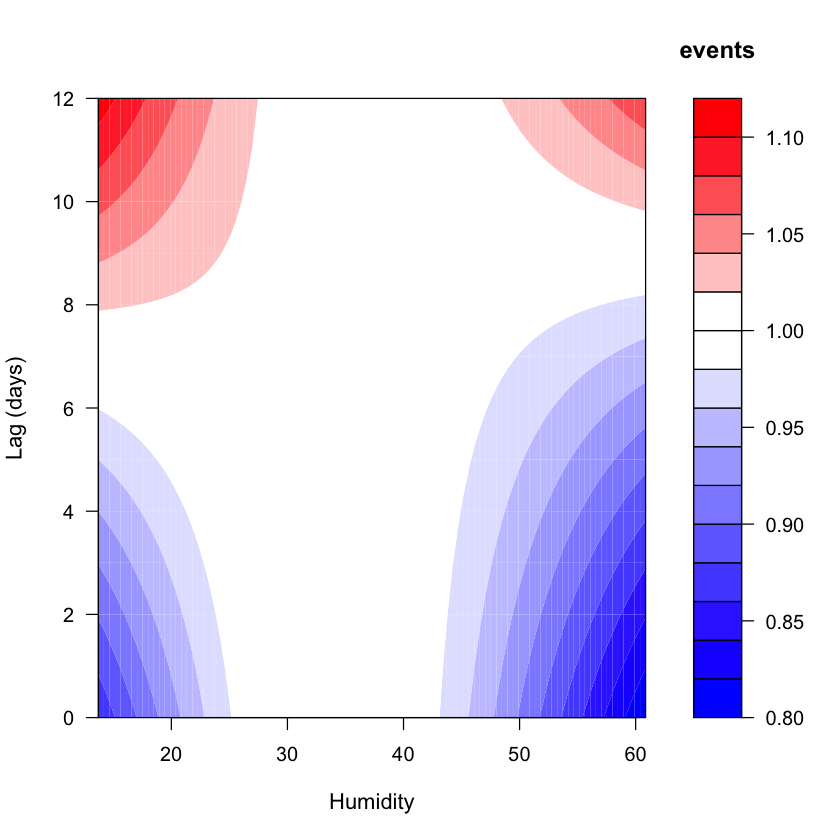

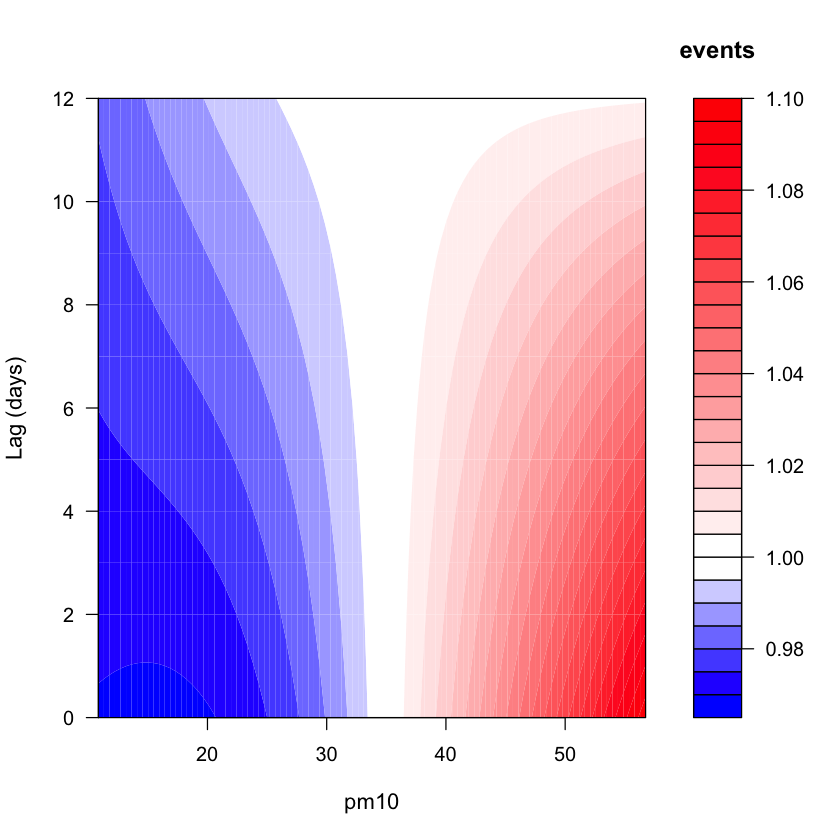

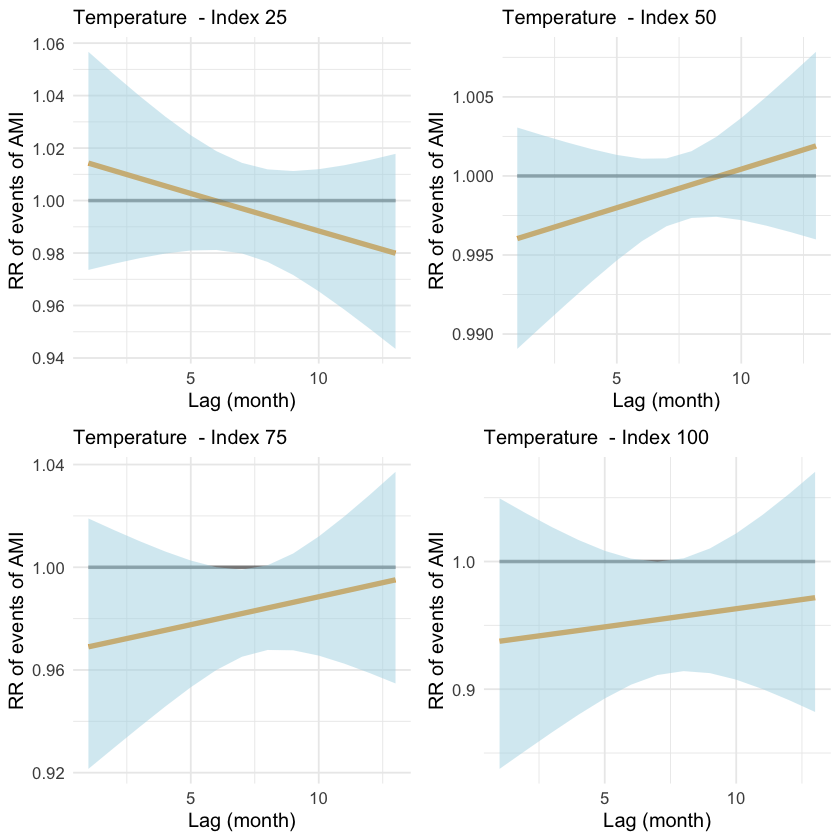

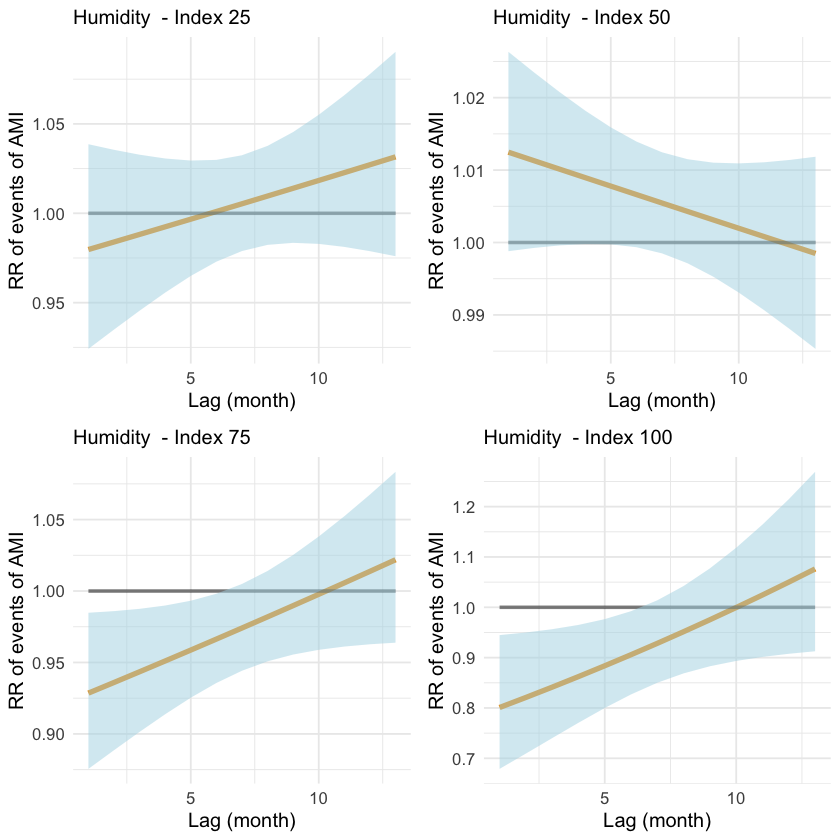

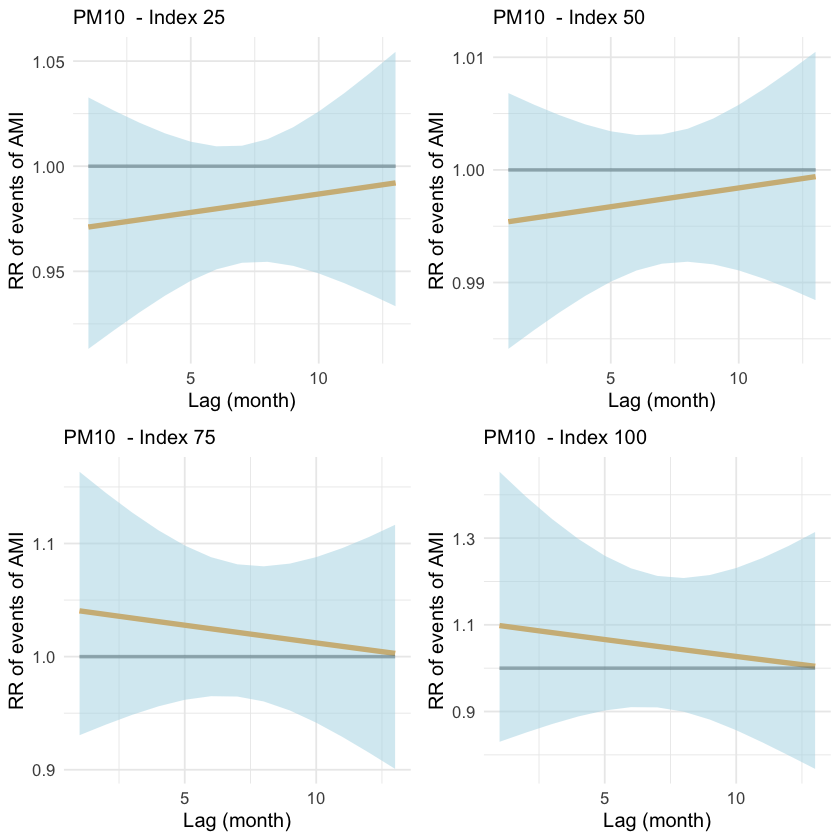

In [76]:
################################################################################
# READ DATA
################################################################################
data <- read.csv("modelling_data/weekly_data.csv")
################################################################################
# DATA VARIABLES SPLIT
# ################################################################################
data <- data %>% dplyr:::select(
                                at_code,
                                events,
                                temp = max_temp,
                                hum = min_hum,
                                is_holiday,
                                month,
                                year,
                                pm10 = mean_PM10,
                                o3 = mean_O3,
                                no2 = mean_NO2,
                                so2 = mean_SO2,
                                co = mean_CO
                                )

# ################################################################################
# AT CODE
# ################################################################################
data = data[(data$at_code=="AT03"),]

# ################################################################################
# CROSS BASIS FUNCTIONS WITH GIVEN DF AND VARIABLES
# ################################################################################
# Create crossbasis for mean_PM10 and min_hum and ozone
cb_pm10 <- crossbasis(data$pm10, lag=12, 
                      argvar=list(fun="ns", df=2), 
                      arglag=list(fun="ns", df=2))

cb_hum <- crossbasis(data$hum, lag=12, 
                         argvar=list(fun="ns", df=2), 
                         arglag=list(fun="ns", df=2))

cb_no2 <- crossbasis(data$no2, lag=12, 
                         argvar=list(fun="ns", df=2), 
                         arglag=list(fun="ns", df=2))

cb_temp <- crossbasis(data$temp, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))

cb_so2 <- crossbasis(data$so2, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))

cb_co <- crossbasis(data$co, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))
# ################################################################################
# MODEL FITTING
# ################################################################################
# Fit DLNM including min_hum
model <- glm(events ~ cb_pm10 + cb_hum + cb_temp + ns(year, df=3) + is_holiday, 
             data = data, family = quasipoisson)
# ################################################################################
# SUMMARY
# ################################################################################
# Summary of the model
summary(model)
# ################################################################################
# DIAGNOSTICS
# ################################################################################
par(mfrow = c(2, 2))
plot(model$residuals, main="Residuals of the Model", ylab="Residuals", xlab="Index")
abline(h=0, col="red")

qqnorm(model$residuals)
qqline(model$residuals, col="red")

acf(model$residuals)
pacf(model$residuals)

# ################################################################################
# RESULTS
# ################################################################################

# Create crosspred object for visualization of temp
pred_temp <- crosspred(cb_temp, model, at=seq(min(data$temp), max(data$temp), length=100))

# Create crosspred object for visualization of hum
pred_hum <- crosspred(cb_hum, model, at=seq(min(data$hum), max(data$hum), length=100))

# Create crosspred object for visualization of pm10
pred_pm10 <- crosspred(cb_pm10, model, at=seq(min(data$pm10), max(data$pm10), length=100))

# ################################################################################
# SLICES
# ################################################################################
par(mfrow = c(2, 2))
plot(pred_temp, "slices", xlab="Temperature", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")
plot(pred_hum, "slices", xlab="Humidity", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")
plot(pred_pm10, "slices", xlab="PM10", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")

# ################################################################################
# CONTOURS
# ################################################################################
par(mfrow = c(1, 1))
# 3D, contour, and curve plots for temperature
#plot(pred_temp, xlab="Temperature", ylab="Lag (days)", zlab="RR of events of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="")
plot(pred_temp, "contour", key.title=title("events"), plot.title=title("", xlab ="Temperature", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# 3D, contour, and curve plots for humidity
#plot(pred_hum, xlab="Humidity", ylab="Lag (days)", zlab="RR of events of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="")
plot(pred_hum, "contour", key.title=title("events"), plot.title=title("", xlab ="Humidity", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# 3D, contour, and curve plots for pm10
plot(pred_pm10, "contour", key.title=title("events"), plot.title=title("", xlab ="pm10", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# ################################################################################
# LAGS
# ################################################################################
library(ggplot2)
library(gridExtra)
library(dlnm)  # Assuming you are using the dlnm package for crosspred

# Function to extract a specific row by index and create a lag plot data frame
create_lag_plot_by_index <- function(pred_obj, index) {
  data.frame(
    index = 1:ncol(pred_obj$matRRfit),
    RRfit = as.numeric(pred_obj$matRRfit[index, ]),
    RRlow = as.numeric(pred_obj$matRRlow[index, ]),
    RRhigh = as.numeric(pred_obj$matRRhigh[index, ])
  )
}

# Specify the indices you are interested in
indices <- c(25, 50, 75, 100)

# Create lag plots for each crosspred object and index
lag_plots_temp <- lapply(indices, function(idx) create_lag_plot_by_index(pred_temp, idx))
lag_plots_hum <- lapply(indices, function(idx) create_lag_plot_by_index(pred_hum, idx))
lag_plots_pm10 <- lapply(indices, function(idx) create_lag_plot_by_index(pred_pm10, idx))

# Function to plot data
plot_lag <- function(data, xlab, ylab, main, index) {
  ggplot(data, aes(x = index)) +
    geom_line(aes(y = RRfit), color = "orange2", size = 1.5) +
    geom_line(aes(y = 1), color = "black", size = 1, alpha = 0.5) +
    geom_ribbon(aes(ymin = RRlow, ymax = RRhigh), fill = "lightblue", alpha = 0.5) +
    labs(title = paste(main, " - Index", index), x = xlab, y = ylab) +
    theme_minimal() +
    theme(
      text = element_text(size = 10),
      axis.title = element_text(size = 12),
      axis.text = element_text(size = 10)
    )
}

# Create individual plots for each index
plots_temp <- lapply(1:length(indices), function(i) plot_lag(lag_plots_temp[[i]], "Lag (month)", "RR of events of AMI", "Temperature", indices[i]))
plots_hum <- lapply(1:length(indices), function(i) plot_lag(lag_plots_hum[[i]], "Lag (month)", "RR of events of AMI", "Humidity", indices[i]))
plots_pm10 <- lapply(1:length(indices), function(i) plot_lag(lag_plots_pm10[[i]], "Lag (month)", "RR of events of AMI", "PM10", indices[i]))

# Arrange the plots in a grid (2x2 for each pollutant)
grid.arrange(grobs = plots_temp, nrow = 2, ncol = 2)
grid.arrange(grobs = plots_hum, nrow = 2, ncol = 2)
grid.arrange(grobs = plots_pm10, nrow = 2, ncol = 2)



# BEST MODEL AT01 - events

In [77]:
dlnm_selection01 <- read.csv("dlnm_tuning/AT01_best_model_weekly.csv")

# Select distinct rows based on the 'variables' column
dlnm_selection01_unique <- dlnm_selection01 %>%
  distinct(variables, .keep_all = TRUE)

# Display the resulting dataframe
dlnm_selection01_unique

model,variables,df_pm10,df_hum,df_no2,df_temp,df_so2,df_co,is_holiday,residual_deviance,AIC,data_split,year_df
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<chr>,<int>
Model 1,hum + temp + pm10 + o3 + no2 + so2 + co,"2,2","2,2","2,2","2,2","2,2","2,2",FALSE,551.7206,3050.083,max,3
Model 1,hum + temp + pm10 + o3 + no2 + so2 + co + is_holiday,"2,2","2,2","2,2","2,2","2,2","2,2",TRUE,550.9398,3051.302,max,3
Model 1,hum + temp + no2,"2,2","2,2","2,2","2,2","2,2","2,2",FALSE,562.6019,3052.964,max,3
Model 1,hum + temp + no2 + is_holiday,"2,2","2,2","2,2","2,2","2,2","2,2",TRUE,562.3181,3054.681,max,3
Model 1,hum + temp + pm10,"2,2","2,2","2,2","2,2","2,2","2,2",FALSE,565.3367,3055.699,max,3
Model 1,hum + temp + pm10 + is_holiday,"2,2","2,2","2,2","2,2","2,2","2,2",TRUE,565.2376,3057.600,max,3
Model 1,temp,"2,2","2,2","2,2","2,2","2,2","2,2",FALSE,577.5829,3063.945,max,3
Model 1,hum + temp,"2,2","2,2","2,2","2,2","2,2","2,2",FALSE,577.4354,3065.798,max,3
Model 1,temp + is_holiday,"2,2","2,2","2,2","2,2","2,2","2,2",TRUE,577.5824,3065.945,max,3



Call:
glm(formula = events ~ cb_pm10 + cb_hum + cb_temp + cb_so2 + 
    ns(year, df = 3), family = quasipoisson, data = data)

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        3.043732   0.249288  12.210  < 2e-16 ***
cb_pm10v1.l1       0.029639   0.040796   0.727 0.467912    
cb_pm10v1.l2      -0.010608   0.053689  -0.198 0.843461    
cb_pm10v2.l1       0.034865   0.038078   0.916 0.360365    
cb_pm10v2.l2      -0.040367   0.042714  -0.945 0.345149    
cb_humv1.l1        0.054352   0.047383   1.147 0.251973    
cb_humv1.l2        0.064900   0.061373   1.057 0.290879    
cb_humv2.l1       -0.094806   0.040467  -2.343 0.019586 *  
cb_humv2.l2       -0.094728   0.045430  -2.085 0.037635 *  
cb_tempv1.l1      -0.054034   0.040934  -1.320 0.187523    
cb_tempv1.l2      -0.007598   0.055666  -0.136 0.891493    
cb_tempv2.l1      -0.056279   0.013745  -4.094 5.04e-05 ***
cb_tempv2.l2       0.095802   0.023816   4.023 6.78e-05 ***
cb_so2v1.l1       

centering value unspecified. Automatically set to 22.5

centering value unspecified. Automatically set to 35

centering value unspecified. Automatically set to 30

centering value unspecified. Automatically set to 6



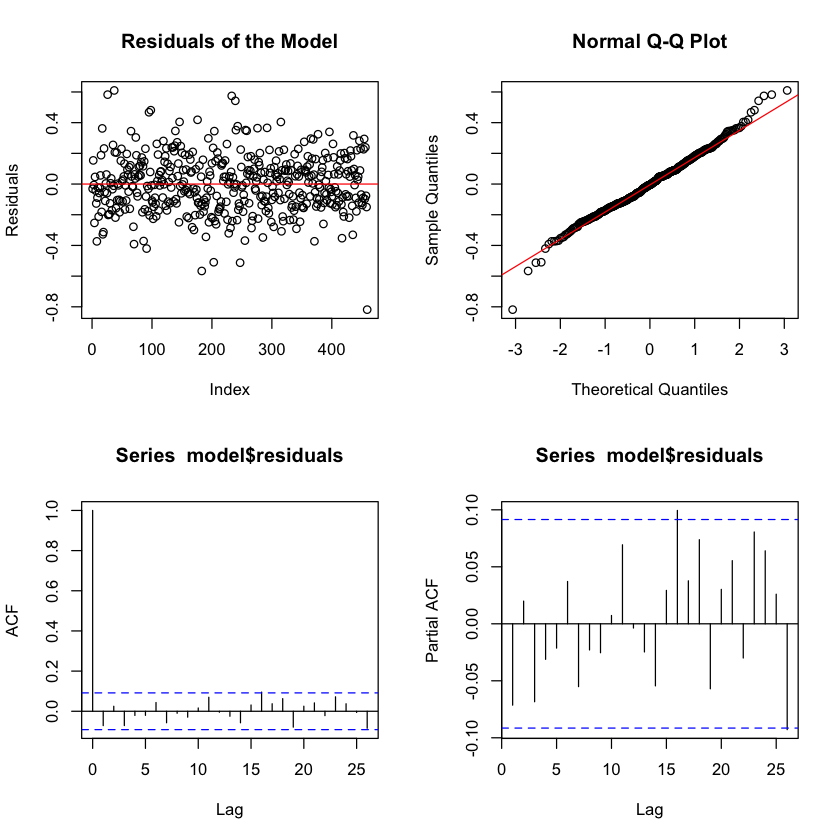

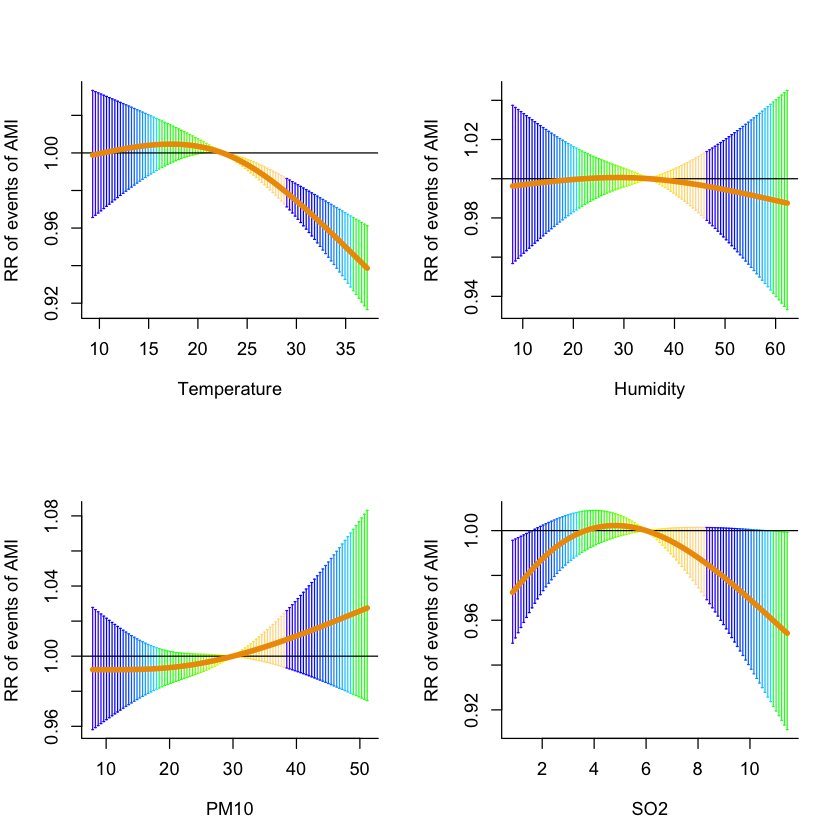

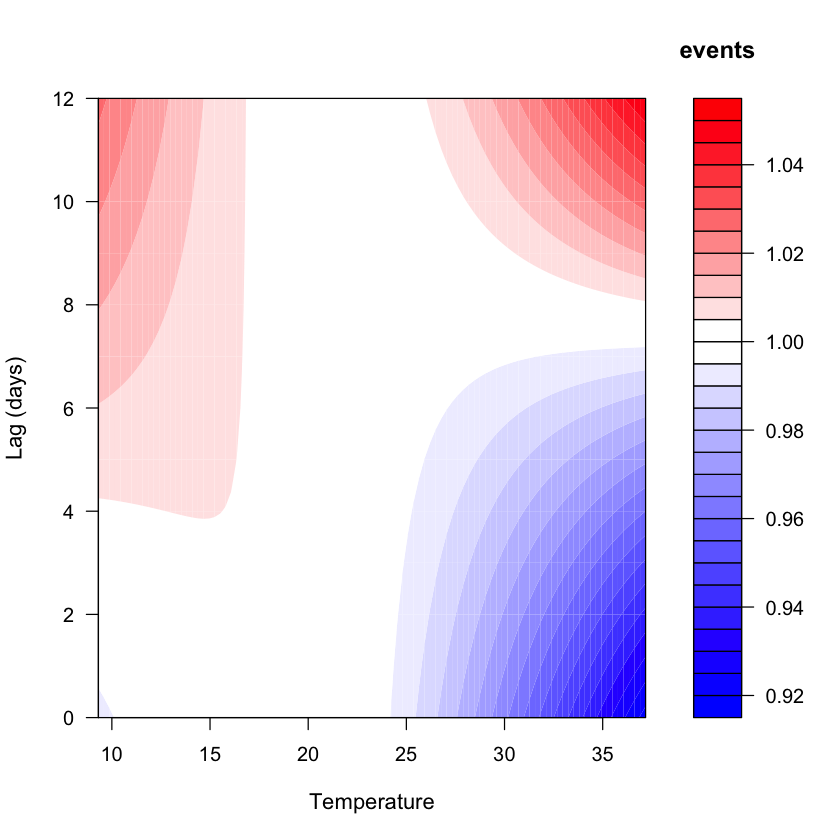

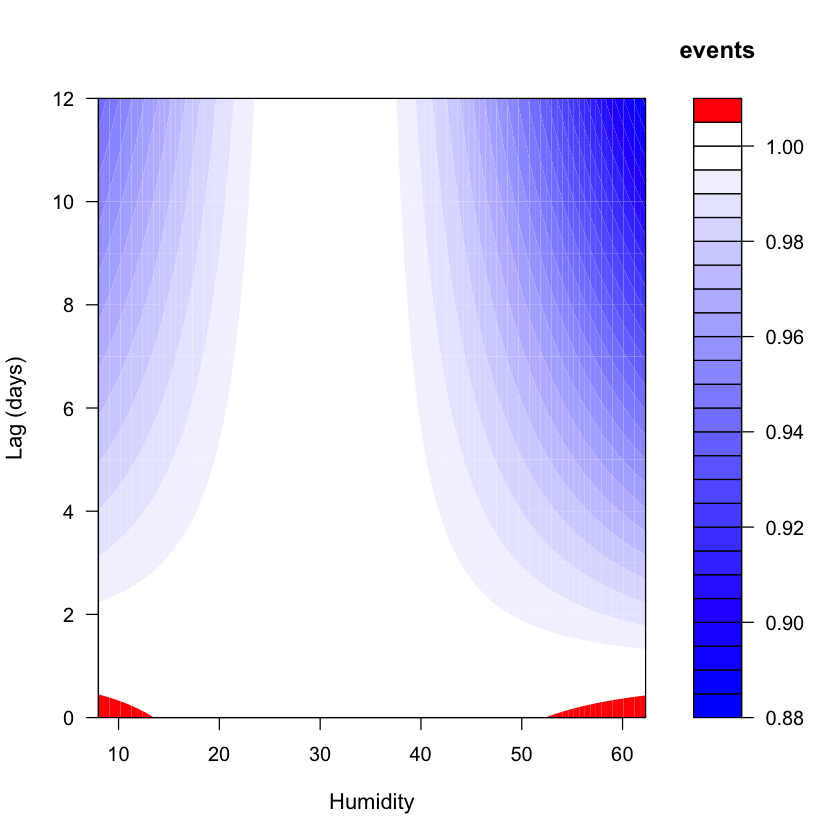

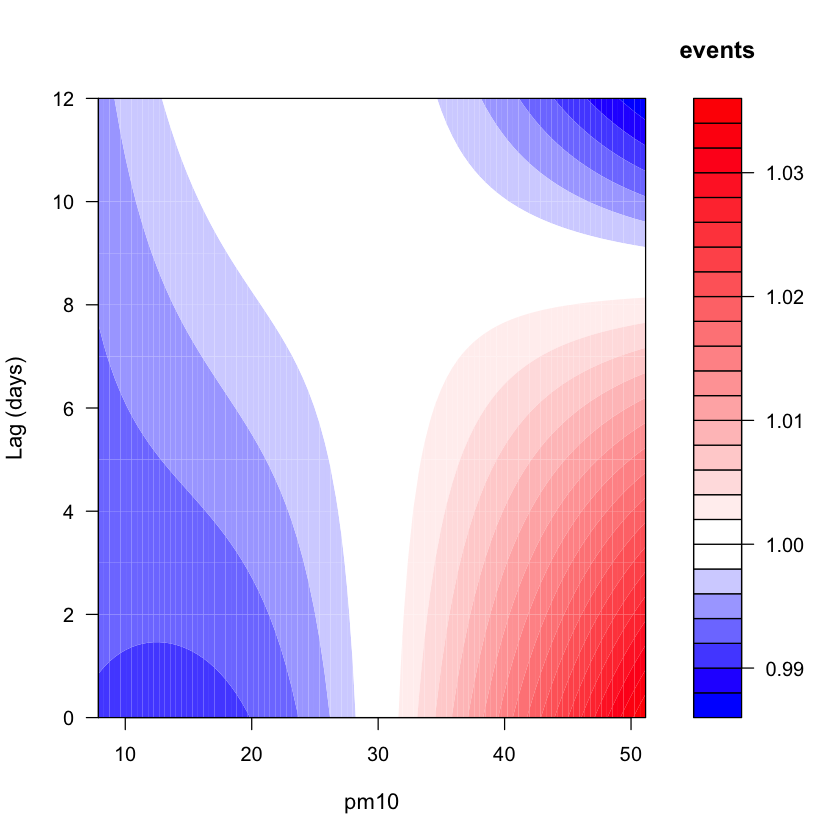

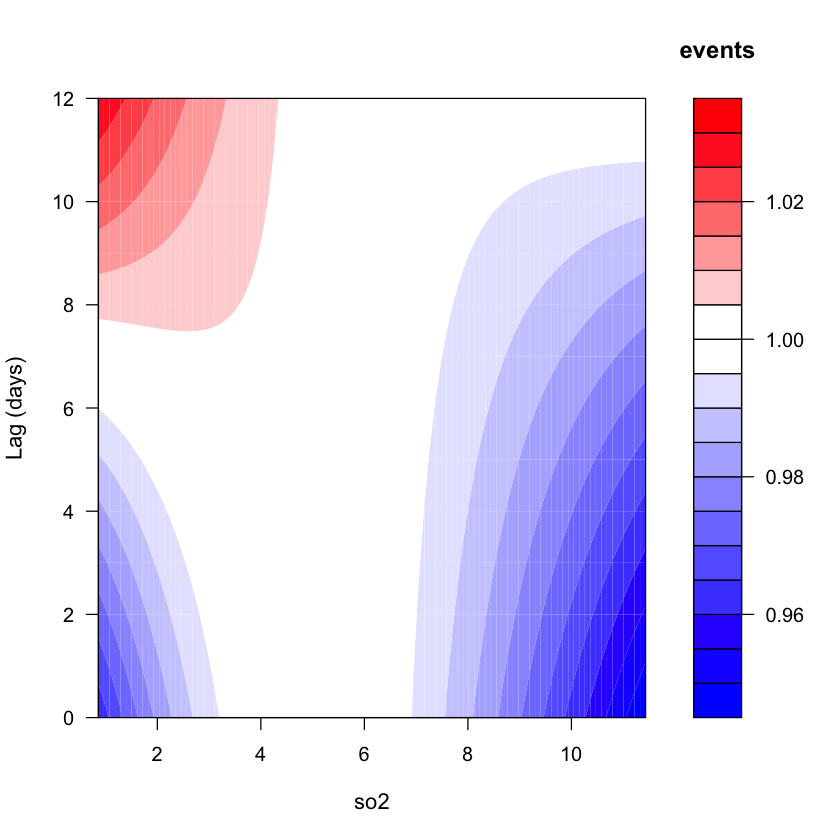

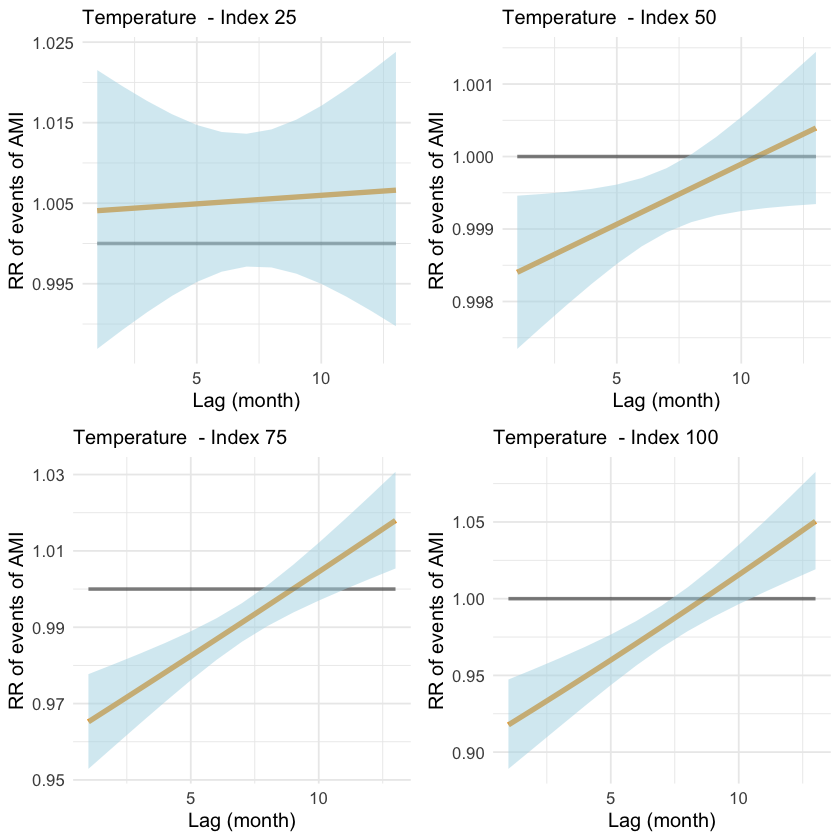

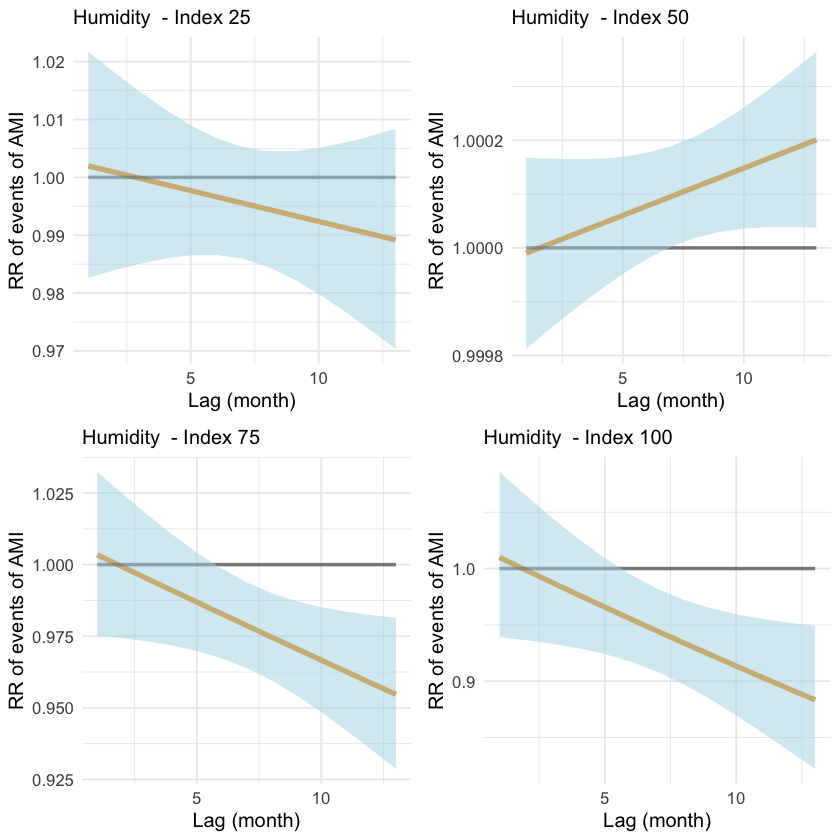

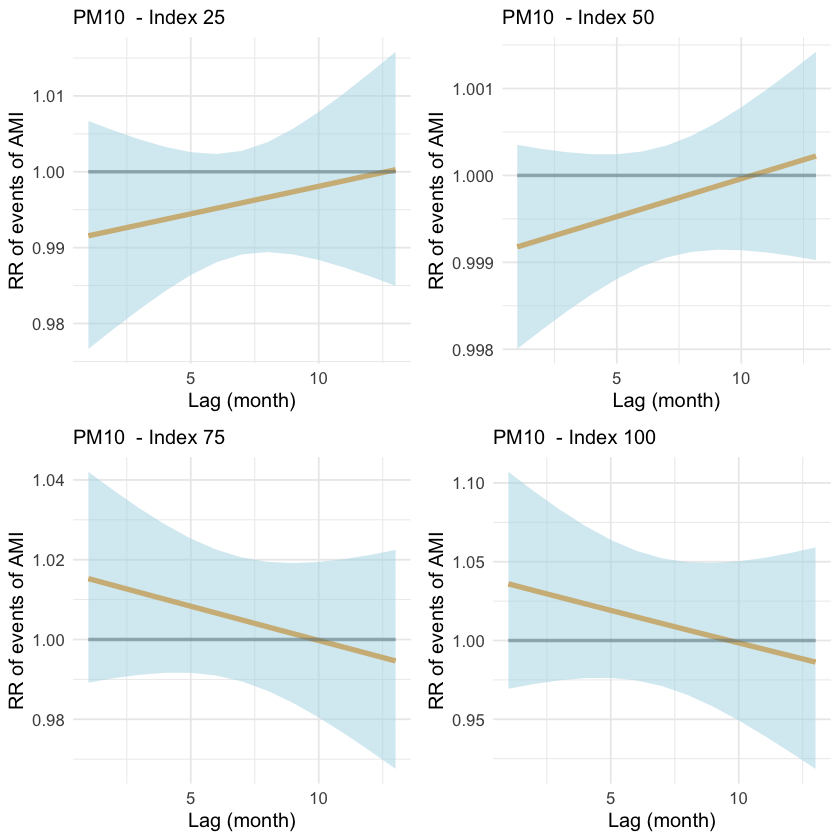

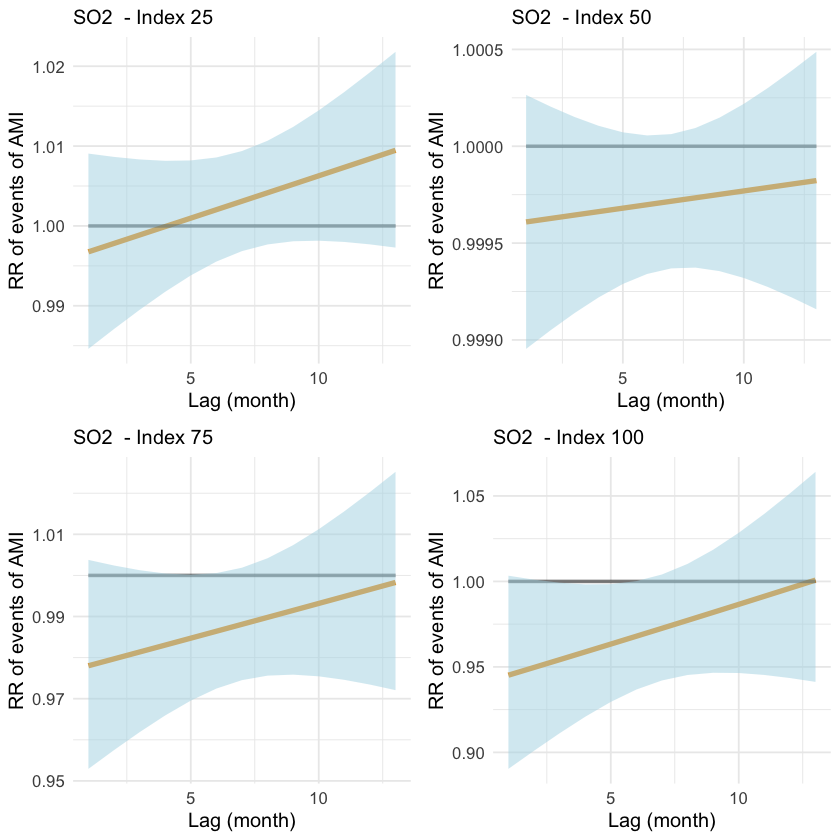

In [84]:
################################################################################
# READ DATA
################################################################################
data <- read.csv("modelling_data/weekly_data.csv")
################################################################################
# DATA VARIABLES SPLIT
# ################################################################################
data <- data %>% dplyr:::select(
                                at_code,
                                events,
                                temp = max_temp,
                                hum = min_hum,
                                is_holiday,
                                month,
                                year,
                                pm10 = mean_PM10,
                                o3 = mean_O3,
                                no2 = mean_NO2,
                                so2 = mean_SO2,
                                co = mean_CO
                                )

# ################################################################################
# AT CODE
# ################################################################################
data = data[(data$at_code=="AT01"),]

# ################################################################################
# CROSS BASIS FUNCTIONS WITH GIVEN DF AND VARIABLES
# ################################################################################
# Create crossbasis for mean_PM10 and min_hum and ozone
cb_pm10 <- crossbasis(data$pm10, lag=12, 
                      argvar=list(fun="ns", df=2), 
                      arglag=list(fun="ns", df=2))

cb_hum <- crossbasis(data$hum, lag=12, 
                         argvar=list(fun="ns", df=2), 
                         arglag=list(fun="ns", df=2))

cb_no2 <- crossbasis(data$no2, lag=12, 
                         argvar=list(fun="ns", df=2), 
                         arglag=list(fun="ns", df=2))

cb_temp <- crossbasis(data$temp, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))

cb_so2 <- crossbasis(data$so2, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))

cb_co <- crossbasis(data$co, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))

cb_o3 <- crossbasis(data$o3, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))
                    

# ################################################################################
# MODEL FITTING
# ################################################################################
# Fit DLNM including min_hum
model <- glm(events ~ cb_pm10 + cb_hum + cb_temp + cb_so2 + ns(year, df=3), 
             data = data, family = quasipoisson)
# ################################################################################
# SUMMARY
# ################################################################################
# Summary of the model
summary(model)
# ################################################################################
# DIAGNOSTICS
# ################################################################################
par(mfrow = c(2, 2))
plot(model$residuals, main="Residuals of the Model", ylab="Residuals", xlab="Index")
abline(h=0, col="red")

qqnorm(model$residuals)
qqline(model$residuals, col="red")

acf(model$residuals)
pacf(model$residuals)

# ################################################################################
# RESULTS
# ################################################################################

# Create crosspred object for visualization of temp
pred_temp <- crosspred(cb_temp, model, at=seq(min(data$temp), max(data$temp), length=100))

# Create crosspred object for visualization of hum
pred_hum <- crosspred(cb_hum, model, at=seq(min(data$hum), max(data$hum), length=100))

# Create crosspred object for visualization of pm10
pred_pm10 <- crosspred(cb_pm10, model, at=seq(min(data$pm10), max(data$pm10), length=100))

# Create crosspred object for visualization of pm10
pred_so2 <- crosspred(cb_so2, model, at=seq(min(data$so2), max(data$so2), length=100))

# ################################################################################
# SLICES
# ################################################################################
par(mfrow = c(2, 2))
plot(pred_temp, "slices", xlab="Temperature", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")
plot(pred_hum, "slices", xlab="Humidity", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")
plot(pred_pm10, "slices", xlab="PM10", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")
plot(pred_so2, "slices", xlab="SO2", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")

# ################################################################################
# CONTOURS
# ################################################################################
par(mfrow = c(1, 1))
# 3D, contour, and curve plots for temperature
#plot(pred_temp, xlab="Temperature", ylab="Lag (days)", zlab="RR of events of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="")
plot(pred_temp, "contour", key.title=title("events"), plot.title=title("", xlab ="Temperature", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# 3D, contour, and curve plots for humidity
#plot(pred_hum, xlab="Humidity", ylab="Lag (days)", zlab="RR of events of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="")
plot(pred_hum, "contour", key.title=title("events"), plot.title=title("", xlab ="Humidity", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# 3D, contour, and curve plots for pm10
plot(pred_pm10, "contour", key.title=title("events"), plot.title=title("", xlab ="pm10", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# 3D, contour, and curve plots for pm10
plot(pred_so2, "contour", key.title=title("events"), plot.title=title("", xlab ="so2", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# ################################################################################
# LAGS
# ################################################################################
library(ggplot2)
library(gridExtra)
library(dlnm)  # Assuming you are using the dlnm package for crosspred

# Function to extract a specific row by index and create a lag plot data frame
create_lag_plot_by_index <- function(pred_obj, index) {
  data.frame(
    index = 1:ncol(pred_obj$matRRfit),
    RRfit = as.numeric(pred_obj$matRRfit[index, ]),
    RRlow = as.numeric(pred_obj$matRRlow[index, ]),
    RRhigh = as.numeric(pred_obj$matRRhigh[index, ])
  )
}

# Specify the indices you are interested in
indices <- c(25, 50, 75, 100)

# Create lag plots for each crosspred object and index
lag_plots_temp <- lapply(indices, function(idx) create_lag_plot_by_index(pred_temp, idx))
lag_plots_hum <- lapply(indices, function(idx) create_lag_plot_by_index(pred_hum, idx))
lag_plots_pm10 <- lapply(indices, function(idx) create_lag_plot_by_index(pred_pm10, idx))
lag_plots_so2 <- lapply(indices, function(idx) create_lag_plot_by_index(pred_so2, idx))

# Function to plot data
plot_lag <- function(data, xlab, ylab, main, index) {
  ggplot(data, aes(x = index)) +
    geom_line(aes(y = RRfit), color = "orange2", size = 1.5) +
    geom_line(aes(y = 1), color = "black", size = 1, alpha = 0.5) +
    geom_ribbon(aes(ymin = RRlow, ymax = RRhigh), fill = "lightblue", alpha = 0.5) +
    labs(title = paste(main, " - Index", index), x = xlab, y = ylab) +
    theme_minimal() +
    theme(
      text = element_text(size = 10),
      axis.title = element_text(size = 12),
      axis.text = element_text(size = 10)
    )
}

# Create individual plots for each index
plots_temp <- lapply(1:length(indices), function(i) plot_lag(lag_plots_temp[[i]], "Lag (month)", "RR of events of AMI", "Temperature", indices[i]))
plots_hum <- lapply(1:length(indices), function(i) plot_lag(lag_plots_hum[[i]], "Lag (month)", "RR of events of AMI", "Humidity", indices[i]))
plots_pm10 <- lapply(1:length(indices), function(i) plot_lag(lag_plots_pm10[[i]], "Lag (month)", "RR of events of AMI", "PM10", indices[i]))
plots_so2 <- lapply(1:length(indices), function(i) plot_lag(lag_plots_so2[[i]], "Lag (month)", "RR of events of AMI", "SO2", indices[i]))

# Arrange the plots in a grid (2x2 for each pollutant)
grid.arrange(grobs = plots_temp, nrow = 2, ncol = 2)
grid.arrange(grobs = plots_hum, nrow = 2, ncol = 2)
grid.arrange(grobs = plots_pm10, nrow = 2, ncol = 2)
grid.arrange(grobs = plots_so2, nrow = 2, ncol = 2)



# BEST MODEL AT03 - ASIR

In [ ]:
dlnm_selection03 <- read.csv("dlnm_tuning/AT03_best_model_weekly_asir.csv")

# Select distinct rows based on the 'variables' column
dlnm_selection03_unique <- dlnm_selection03 %>%
  distinct(variables, .keep_all = TRUE)

# Display the resulting dataframe
dlnm_selection03_unique

In [ ]:
################################################################################
# READ DATA
################################################################################
data <- read.csv("modelling_data/weekly_data.csv")
################################################################################
# DATA VARIABLES SPLIT
# ################################################################################
data <- data %>% dplyr:::select(
                                at_code,
                                events,
                                asir,
                                temp = max_temp,
                                hum = min_hum,
                                is_holiday,
                                month,
                                year,
                                pm10 = mean_PM10,
                                o3 = mean_O3,
                                no2 = mean_NO2,
                                so2 = mean_SO2,
                                co = mean_CO
                                )

# ################################################################################
# AT CODE
# ################################################################################
data = data[(data$at_code=="AT03"),]

# ################################################################################
# CROSS BASIS FUNCTIONS WITH GIVEN DF AND VARIABLES
# ################################################################################
# Create crossbasis for mean_PM10 and min_hum and ozone
cb_pm10 <- crossbasis(data$pm10, lag=12, 
                      argvar=list(fun="ns", df=2), 
                      arglag=list(fun="ns", df=2))

cb_hum <- crossbasis(data$hum, lag=12, 
                         argvar=list(fun="ns", df=2), 
                         arglag=list(fun="ns", df=2))

cb_no2 <- crossbasis(data$no2, lag=12, 
                         argvar=list(fun="ns", df=2), 
                         arglag=list(fun="ns", df=2))

cb_temp <- crossbasis(data$temp, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))

cb_so2 <- crossbasis(data$so2, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))

cb_co <- crossbasis(data$co, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))
# ################################################################################
# MODEL FITTING
# ################################################################################
# Fit DLNM including min_hum
model <- glm(asir ~ cb_pm10 + cb_hum + cb_temp + ns(year, df=3) + is_holiday, 
             data = data, family = quasipoisson)
# ################################################################################
# SUMMARY
# ################################################################################
# Summary of the model
summary(model)
# ################################################################################
# DIAGNOSTICS
# ################################################################################
par(mfrow = c(2, 2))
plot(model$residuals, main="Residuals of the Model", ylab="Residuals", xlab="Index")
abline(h=0, col="red")

qqnorm(model$residuals)
qqline(model$residuals, col="red")

acf(model$residuals)
pacf(model$residuals)

# ################################################################################
# RESULTS
# ################################################################################

# Create crosspred object for visualization of temp
pred_temp <- crosspred(cb_temp, model, at=seq(min(data$temp), max(data$temp), length=100))

# Create crosspred object for visualization of hum
pred_hum <- crosspred(cb_hum, model, at=seq(min(data$hum), max(data$hum), length=100))

# Create crosspred object for visualization of pm10
pred_pm10 <- crosspred(cb_pm10, model, at=seq(min(data$pm10), max(data$pm10), length=100))

# ################################################################################
# SLICES
# ################################################################################
par(mfrow = c(2, 2))
plot(pred_temp, "slices", xlab="Temperature", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")
plot(pred_hum, "slices", xlab="Humidity", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")
plot(pred_pm10, "slices", xlab="PM10", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")

# ################################################################################
# CONTOURS
# ################################################################################
par(mfrow = c(1, 1))
# 3D, contour, and curve plots for temperature
#plot(pred_temp, xlab="Temperature", ylab="Lag (days)", zlab="RR of events of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="")
plot(pred_temp, "contour", key.title=title("events"), plot.title=title("", xlab ="Temperature", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# 3D, contour, and curve plots for humidity
#plot(pred_hum, xlab="Humidity", ylab="Lag (days)", zlab="RR of events of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="")
plot(pred_hum, "contour", key.title=title("events"), plot.title=title("", xlab ="Humidity", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# 3D, contour, and curve plots for pm10
plot(pred_pm10, "contour", key.title=title("events"), plot.title=title("", xlab ="pm10", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# ################################################################################
# LAGS
# ################################################################################
library(ggplot2)
library(gridExtra)
library(dlnm)  # Assuming you are using the dlnm package for crosspred

# Function to extract a specific row by index and create a lag plot data frame
create_lag_plot_by_index <- function(pred_obj, index) {
  data.frame(
    index = 1:ncol(pred_obj$matRRfit),
    RRfit = as.numeric(pred_obj$matRRfit[index, ]),
    RRlow = as.numeric(pred_obj$matRRlow[index, ]),
    RRhigh = as.numeric(pred_obj$matRRhigh[index, ])
  )
}

# Specify the indices you are interested in
indices <- c(25, 50, 75, 100)

# Create lag plots for each crosspred object and index
lag_plots_temp <- lapply(indices, function(idx) create_lag_plot_by_index(pred_temp, idx))
lag_plots_hum <- lapply(indices, function(idx) create_lag_plot_by_index(pred_hum, idx))
lag_plots_pm10 <- lapply(indices, function(idx) create_lag_plot_by_index(pred_pm10, idx))

# Function to plot data
plot_lag <- function(data, xlab, ylab, main, index) {
  ggplot(data, aes(x = index)) +
    geom_line(aes(y = RRfit), color = "orange2", size = 1.5) +
    geom_line(aes(y = 1), color = "black", size = 1, alpha = 0.5) +
    geom_ribbon(aes(ymin = RRlow, ymax = RRhigh), fill = "lightblue", alpha = 0.5) +
    labs(title = paste(main, " - Index", index), x = xlab, y = ylab) +
    theme_minimal() +
    theme(
      text = element_text(size = 10),
      axis.title = element_text(size = 12),
      axis.text = element_text(size = 10)
    )
}

# Create individual plots for each index
plots_temp <- lapply(1:length(indices), function(i) plot_lag(lag_plots_temp[[i]], "Lag (month)", "RR of events of AMI", "Temperature", indices[i]))
plots_hum <- lapply(1:length(indices), function(i) plot_lag(lag_plots_hum[[i]], "Lag (month)", "RR of events of AMI", "Humidity", indices[i]))
plots_pm10 <- lapply(1:length(indices), function(i) plot_lag(lag_plots_pm10[[i]], "Lag (month)", "RR of events of AMI", "PM10", indices[i]))

# Arrange the plots in a grid (2x2 for each pollutant)
grid.arrange(grobs = plots_temp, nrow = 2, ncol = 2)
grid.arrange(grobs = plots_hum, nrow = 2, ncol = 2)
grid.arrange(grobs = plots_pm10, nrow = 2, ncol = 2)



# BEST MODEL AT01 - ASIR

In [ ]:
dlnm_selection01 <- read.csv("dlnm_tuning/AT01_best_model_weekly_asir.csv")

# Select distinct rows based on the 'variables' column
dlnm_selection01_unique <- dlnm_selection01 %>%
  distinct(variables, .keep_all = TRUE)

# Display the resulting dataframe
dlnm_selection01_unique

In [ ]:
################################################################################
# READ DATA
################################################################################
data <- read.csv("modelling_data/weekly_data.csv")
################################################################################
# DATA VARIABLES SPLIT
# ################################################################################
data <- data %>% dplyr:::select(
                                at_code,
                                asir,
                                events,
                                temp = max_temp,
                                hum = min_hum,
                                is_holiday,
                                month,
                                year,
                                pm10 = mean_PM10,
                                o3 = mean_O3,
                                no2 = mean_NO2,
                                so2 = mean_SO2,
                                co = mean_CO
                                )

# ################################################################################
# AT CODE
# ################################################################################
data = data[(data$at_code=="AT01"),]

# ################################################################################
# CROSS BASIS FUNCTIONS WITH GIVEN DF AND VARIABLES
# ################################################################################
# Create crossbasis for mean_PM10 and min_hum and ozone
cb_pm10 <- crossbasis(data$pm10, lag=12, 
                      argvar=list(fun="ns", df=2), 
                      arglag=list(fun="ns", df=2))

cb_hum <- crossbasis(data$hum, lag=12, 
                         argvar=list(fun="ns", df=2), 
                         arglag=list(fun="ns", df=2))

cb_no2 <- crossbasis(data$no2, lag=12, 
                         argvar=list(fun="ns", df=2), 
                         arglag=list(fun="ns", df=2))

cb_temp <- crossbasis(data$temp, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))

cb_so2 <- crossbasis(data$so2, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))

cb_co <- crossbasis(data$co, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))

cb_o3 <- crossbasis(data$o3, lag=12, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))
                    

# ################################################################################
# MODEL FITTING
# ################################################################################
# Fit DLNM including min_hum
model <- glm(asir ~ cb_pm10 + cb_hum + cb_temp + cb_so2 + ns(year, df=3), 
             data = data, family = quasipoisson)
# ################################################################################
# SUMMARY
# ################################################################################
# Summary of the model
summary(model)
# ################################################################################
# DIAGNOSTICS
# ################################################################################
par(mfrow = c(2, 2))
plot(model$residuals, main="Residuals of the Model", ylab="Residuals", xlab="Index")
abline(h=0, col="red")

qqnorm(model$residuals)
qqline(model$residuals, col="red")

acf(model$residuals)
pacf(model$residuals)

# ################################################################################
# RESULTS
# ################################################################################

# Create crosspred object for visualization of temp
pred_temp <- crosspred(cb_temp, model, at=seq(min(data$temp), max(data$temp), length=100))

# Create crosspred object for visualization of hum
pred_hum <- crosspred(cb_hum, model, at=seq(min(data$hum), max(data$hum), length=100))

# Create crosspred object for visualization of pm10
pred_pm10 <- crosspred(cb_pm10, model, at=seq(min(data$pm10), max(data$pm10), length=100))

# Create crosspred object for visualization of pm10
pred_so2 <- crosspred(cb_so2, model, at=seq(min(data$so2), max(data$so2), length=100))

# ################################################################################
# SLICES
# ################################################################################
par(mfrow = c(2, 2))
plot(pred_temp, "slices", xlab="Temperature", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")
plot(pred_hum, "slices", xlab="Humidity", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")
plot(pred_pm10, "slices", xlab="PM10", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")
plot(pred_so2, "slices", xlab="SO2", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")

# ################################################################################
# CONTOURS
# ################################################################################
par(mfrow = c(1, 1))
# 3D, contour, and curve plots for temperature
#plot(pred_temp, xlab="Temperature", ylab="Lag (days)", zlab="RR of events of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="")
plot(pred_temp, "contour", key.title=title("events"), plot.title=title("", xlab ="Temperature", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# 3D, contour, and curve plots for humidity
#plot(pred_hum, xlab="Humidity", ylab="Lag (days)", zlab="RR of events of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="")
plot(pred_hum, "contour", key.title=title("events"), plot.title=title("", xlab ="Humidity", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# 3D, contour, and curve plots for pm10
plot(pred_pm10, "contour", key.title=title("events"), plot.title=title("", xlab ="pm10", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# 3D, contour, and curve plots for pm10
plot(pred_so2, "contour", key.title=title("events"), plot.title=title("", xlab ="so2", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# ################################################################################
# LAGS
# ################################################################################
library(ggplot2)
library(gridExtra)
library(dlnm)  # Assuming you are using the dlnm package for crosspred

# Function to extract a specific row by index and create a lag plot data frame
create_lag_plot_by_index <- function(pred_obj, index) {
  data.frame(
    index = 1:ncol(pred_obj$matRRfit),
    RRfit = as.numeric(pred_obj$matRRfit[index, ]),
    RRlow = as.numeric(pred_obj$matRRlow[index, ]),
    RRhigh = as.numeric(pred_obj$matRRhigh[index, ])
  )
}

# Specify the indices you are interested in
indices <- c(25, 50, 75, 100)

# Create lag plots for each crosspred object and index
lag_plots_temp <- lapply(indices, function(idx) create_lag_plot_by_index(pred_temp, idx))
lag_plots_hum <- lapply(indices, function(idx) create_lag_plot_by_index(pred_hum, idx))
lag_plots_pm10 <- lapply(indices, function(idx) create_lag_plot_by_index(pred_pm10, idx))
lag_plots_so2 <- lapply(indices, function(idx) create_lag_plot_by_index(pred_so2, idx))

# Function to plot data
plot_lag <- function(data, xlab, ylab, main, index) {
  ggplot(data, aes(x = index)) +
    geom_line(aes(y = RRfit), color = "orange2", size = 1.5) +
    geom_line(aes(y = 1), color = "black", size = 1, alpha = 0.5) +
    geom_ribbon(aes(ymin = RRlow, ymax = RRhigh), fill = "lightblue", alpha = 0.5) +
    labs(title = paste(main, " - Index", index), x = xlab, y = ylab) +
    theme_minimal() +
    theme(
      text = element_text(size = 10),
      axis.title = element_text(size = 12),
      axis.text = element_text(size = 10)
    )
}

# Create individual plots for each index
plots_temp <- lapply(1:length(indices), function(i) plot_lag(lag_plots_temp[[i]], "Lag (month)", "RR of events of AMI", "Temperature", indices[i]))
plots_hum <- lapply(1:length(indices), function(i) plot_lag(lag_plots_hum[[i]], "Lag (month)", "RR of events of AMI", "Humidity", indices[i]))
plots_pm10 <- lapply(1:length(indices), function(i) plot_lag(lag_plots_pm10[[i]], "Lag (month)", "RR of events of AMI", "PM10", indices[i]))
plots_so2 <- lapply(1:length(indices), function(i) plot_lag(lag_plots_so2[[i]], "Lag (month)", "RR of events of AMI", "SO2", indices[i]))

# Arrange the plots in a grid (2x2 for each pollutant)
grid.arrange(grobs = plots_temp, nrow = 2, ncol = 2)
grid.arrange(grobs = plots_hum, nrow = 2, ncol = 2)
grid.arrange(grobs = plots_pm10, nrow = 2, ncol = 2)
grid.arrange(grobs = plots_so2, nrow = 2, ncol = 2)


# SCRIPTS

In [ ]:
################################################################################
# DATA VARIABLES SPLIT
################################################################################
# MIN
################################################################################
# data <- data %>% dplyr:::select(
#                                 at_code,
#                                 events,
#                                 temp = min_temp,
#                                 hum = min_hum,
#                                 is_holiday,
#                                 month,
#                                 year,
#                                 pm10 = min_PM10,
#                                 o3 = min_O3,
#                                 no2 = min_NO2,
#                                 so2 = min_SO2,
#                                 co = min_CO
#                                 )

# ################################################################################
# # MAX
# ################################################################################
# data <- data %>% dplyr:::select(
#                                 at_code,
#                                 events,
#                                 temp = max_temp,
#                                 hum = max_hum,
#                                 is_holiday,
#                                 month,
#                                 year,
#                                 pm10 = max_PM10,
#                                 o3 = max_O3,
#                                 no2 = max_NO2,
#                                 so2 = max_SO2,
#                                 co = max_CO
#                                 )

################################################################################
# MEAN
# ################################################################################
#  data <- data %>% dplyr:::mutate(
#     mean_temp = (max_temp + min_temp) / 2,
#     mean_hum = (max_hum + min_hum) / 2
#           ) %>% dplyr:::select(
#                                 at_code,
#                                 events,
#                                 temp = mean_temp,
#                                 hum = mean_hum,
#                                 is_holiday,
#                                 month,
#                                 year,
#                                 pm10 = mean_PM10,
#                                 o3 = mean_O3,
#                                 no2 = mean_NO2,
#                                 so2 = mean_SO2,
#                                 co = mean_CO
#                                 )

# ################################################################################
# # MIX
# ################################################################################
# data <- data %>% dplyr:::select(
#                                 at_code,
#                                 events,
#                                 temp = max_temp,
#                                 hum = min_hum,
#                                 is_holiday,
#                                 month,
#                                 year,
#                                 pm10 = mean_PM10,
#                                 o3 = mean_O3,
#                                 no2 = mean_NO2,
#                                 so2 = mean_SO2,
#                                 co = mean_CO
#                                 )